# Notebook 5: Masked Analytics — Missing Data Workflows

## Introduction

This notebook demonstrates how to handle **missing data** using **masked operations**.

**Key question**: When sensor data contains missing values (sensor failures, transmission errors, maintenance windows), how do you compute statistics on **only the valid data points**?

We'll use environmental sensor data with occasional missing readings.

---

## Use Case: Environmental Monitoring

Imagine an environmental monitoring station measuring:
- Temperature
- Humidity
- Atmospheric pressure
- PM2.5 air pollution
- CO2 concentration

Due to sensor failures, wireless transmission errors, or maintenance, some readings are **missing**.

**Standard approach**: Replace missing values with NaN, then use `np.nanmean()`, `np.nanmedian()`, etc.

**HPCSeries approach**: Use **masked operations** that skip invalid data points efficiently.

---

## Setup

Import HPCSeries and load the environmental sensor data with missing values.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hpcs
import time

# Display library info
print(f"HPCSeries version: {hpcs.__version__}")
print(f"SIMD ISA: {hpcs.simd_info()['isa']}")
print()

HPCSeries version: 0.7.0
SIMD ISA: AVX2



[SIMD] Registered OpenMP SIMD reduction kernels
[SIMD] Registered OpenMP SIMD rolling operations
[SIMD] Z-score kernels initialized
[SIMD Debug] AVX-512=0, AVX2=1, AVX=1, SSE2=1
[SIMD] Detected ISA: AVX2 (256-bit)


=== HPCS CPU Detection v0.5 ===
Logical cores:   8
Physical cores:  4
Optimal threads: 4

L1 cache (KB):   32
L2 cache (KB):   512
L3 cache (KB):   4096

NUMA nodes:      1
Cores per node:  4

CPU vendor:      AuthenticAMD
SIMD width:      256 bits
Has SSE2:        T
Has AVX:         T
Has AVX2:        T
Has AVX-512:     F
Has NEON:        F
Has FMA3:        T


## Load Data

Load environmental sensor data with missing values (stored as empty strings in CSV, converted to NaN).

In [2]:
# Load environmental sensor data
df = pd.read_csv('data/environmental_sensors_missing.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract sensor columns
sensor_cols = ['temp_C', 'humidity_pct', 'pressure_hPa', 'pm25_ugm3', 'co2_ppm']

# Count missing values
missing_counts = df[sensor_cols].isna().sum()

print(f"Dataset: {len(df)} hourly readings")
print(f"Sensors: {len(sensor_cols)}")
print()
print("Missing value counts:")
for col, count in missing_counts.items():
    pct = (count / len(df)) * 100
    print(f"  {col:15s}: {count:3d} missing ({pct:5.2f}%)")
print()

# Show first few rows
df.head(10)

Dataset: 96 hourly readings
Sensors: 5

Missing value counts:
  temp_C         :   6 missing ( 6.25%)
  humidity_pct   :   4 missing ( 4.17%)
  pressure_hPa   :   7 missing ( 7.29%)
  pm25_ugm3      :   3 missing ( 3.12%)
  co2_ppm        :   0 missing ( 0.00%)



,timestamp,temp_C,humidity_pct,pressure_hPa,pm25_ugm3,co2_ppm
0,2024-01-01 00:00:00,21.3,65.2,1013.2,12.5,410
1,2024-01-01 01:00:00,21.1,66.1,1013.5,11.8,408
2,2024-01-01 02:00:00,20.9,67.3,1013.8,10.9,405
3,2024-01-01 03:00:00,20.7,68.5,1014.1,10.2,403
4,2024-01-01 04:00:00,NaN,69.7,1014.3,9.8,401
5,2024-01-01 05:00:00,20.3,70.9,1014.5,9.5,400
6,2024-01-01 06:00:00,20.5,71.2,NaN,10.1,402
7,2024-01-01 07:00:00,20.9,70.8,1014.7,11.3,407
8,2024-01-01 08:00:00,21.5,69.5,1014.5,13.2,415
9,2024-01-01 09:00:00,22.3,67.8,1014.2,15.7,425


## Visualize Missing Data Pattern

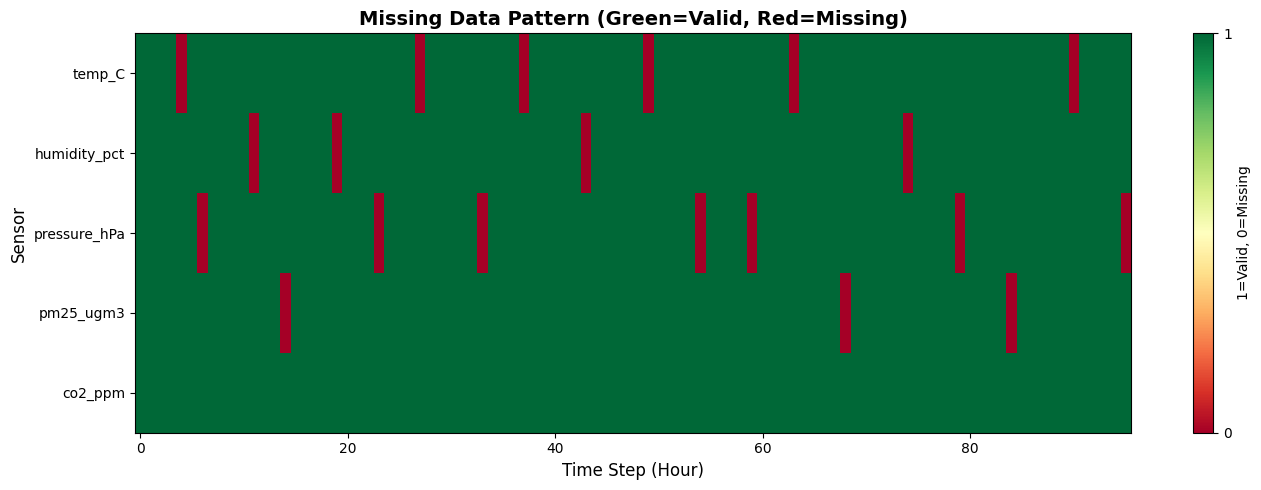

In [3]:
# Create a binary matrix: 1 = valid, 0 = missing
valid_matrix = (~df[sensor_cols].isna()).astype(int)

plt.figure(figsize=(14, 5))
plt.imshow(valid_matrix.T, aspect='auto', cmap='RdYlGn', interpolation='nearest')
plt.colorbar(label='1=Valid, 0=Missing', ticks=[0, 1])
plt.yticks(range(len(sensor_cols)), sensor_cols)
plt.xlabel('Time Step (Hour)', fontsize=12)
plt.ylabel('Sensor', fontsize=12)
plt.title('Missing Data Pattern (Green=Valid, Red=Missing)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Method 1: Standard Approach (Skip Missing Values)

Compute statistics using standard NumPy functions that handle NaN.

In [4]:
print("Standard NumPy Approach (with NaN):")
print("=" * 70)

for col in sensor_cols:
    data = df[col].values
    mean_val = np.nanmean(data)
    median_val = np.nanmedian(data)
    std_val = np.nanstd(data)
    
    print(f"{col:15s}: mean={mean_val:7.2f}, median={median_val:7.2f}, std={std_val:6.2f}")
print()

Standard NumPy Approach (with NaN):
temp_C         : mean=  21.69, median=  21.30, std=  1.46
humidity_pct   : mean=  68.38, median=  69.40, std=  3.71
pressure_hPa   : mean=1013.75, median=1013.80, std=  0.92
pm25_ugm3      : mean=  15.33, median=  13.50, std=  4.52
co2_ppm        : mean= 421.64, median= 410.00, std= 25.31



## Method 2: HPCSeries Masked Operations

Use **masked operations** which explicitly mark valid vs invalid data points.

**Key insight**: Instead of NaN (which requires special checks), use a **boolean mask** where:
- `1` (True) = valid data
- `0` (False) = missing/invalid data

In [6]:
print("HPCSeries Masked Operations:")
print("=" * 70)

for col in sensor_cols:
    data = df[col].values
    
    # Create mask: 1 for valid, 0 for missing
    mask = (~np.isnan(data)).astype(np.int32)
    
    # Replace NaN with 0 (value doesn't matter, mask will skip it)
    data_clean = np.nan_to_num(data, nan=0.0)
    
    # Compute masked statistics
    mean_val = hpcs.mean_masked(data_clean, mask)
    median_val = hpcs.median_masked(data_clean, mask)
    var_val = hpcs.var_masked(data_clean, mask)
    std_val = np.sqrt(var_val)
    
    print(f"{col:15s}: mean={mean_val:7.2f}, median={median_val:7.2f}, std={std_val:6.2f}")
print()

HPCSeries Masked Operations:
temp_C         : mean=  21.69, median=  21.30, std=  1.47
humidity_pct   : mean=  68.38, median=  69.40, std=  3.73
pressure_hPa   : mean=1013.75, median=1013.80, std=  0.93
pm25_ugm3      : mean=  15.33, median=  13.50, std=  4.55
co2_ppm        : mean= 421.64, median= 410.00, std= 25.44



## Comparison: Standard vs Masked

Both approaches should give the same results, but masked operations can be more efficient for large datasets.

In [7]:
# Compare results for temperature
temp_data = df['temp_C'].values
temp_mask = (~np.isnan(temp_data)).astype(np.int32)
temp_clean = np.nan_to_num(temp_data, nan=0.0)

print("Temperature Statistics Comparison:")
print("=" * 70)
print(f"NumPy nanmean:         {np.nanmean(temp_data):.4f}°C")
print(f"HPCSeries mean_masked: {hpcs.mean_masked(temp_clean, temp_mask):.4f}°C")
print()
print(f"NumPy nanmedian:         {np.nanmedian(temp_data):.4f}°C")
print(f"HPCSeries median_masked: {hpcs.median_masked(temp_clean, temp_mask):.4f}°C")
print()
print("✓ Results match! Masked operations produce correct results.")

Temperature Statistics Comparison:
NumPy nanmean:         21.6867°C
HPCSeries mean_masked: 21.6867°C

NumPy nanmedian:         21.3000°C
HPCSeries median_masked: 21.3000°C

✓ Results match! Masked operations produce correct results.


## Use Case: Masked Aggregation

Compute **total valid data coverage** and **data quality score** per sensor.

In [8]:
# Compute data quality metrics
quality_report = []

for col in sensor_cols:
    data = df[col].values
    mask = (~np.isnan(data)).astype(np.int32)
    data_clean = np.nan_to_num(data, nan=0.0)
    
    # Total valid readings
    valid_count = hpcs.sum_masked(np.ones_like(data_clean), mask)
    coverage_pct = (valid_count / len(data)) * 100
    
    # Mean of valid data
    mean_val = hpcs.mean_masked(data_clean, mask)
    
    quality_report.append({
        'sensor': col,
        'valid_readings': int(valid_count),
        'coverage_pct': coverage_pct,
        'mean_value': mean_val
    })

quality_df = pd.DataFrame(quality_report)

print("Sensor Data Quality Report:")
print("=" * 70)
print(quality_df.to_string(index=False))
print()

# Flag sensors with poor coverage
threshold = 95.0
poor_sensors = quality_df[quality_df['coverage_pct'] < threshold]

if len(poor_sensors) > 0:
    print(f"⚠️  Sensors with < {threshold}% coverage:")
    for _, row in poor_sensors.iterrows():
        print(f"  {row['sensor']:15s}: {row['coverage_pct']:.2f}% coverage")
else:
    print(f"✓ All sensors have > {threshold}% coverage.")

Sensor Data Quality Report:
      sensor  valid_readings  coverage_pct  mean_value
      temp_C              90     93.750000   21.686667
humidity_pct              92     95.833333   68.378261
pressure_hPa              89     92.708333 1013.750562
   pm25_ugm3              93     96.875000   15.325806
     co2_ppm              96    100.000000  421.635417

⚠️  Sensors with < 95.0% coverage:
  temp_C         : 93.75% coverage
  pressure_hPa   : 92.71% coverage


## Visualize Valid Data Coverage

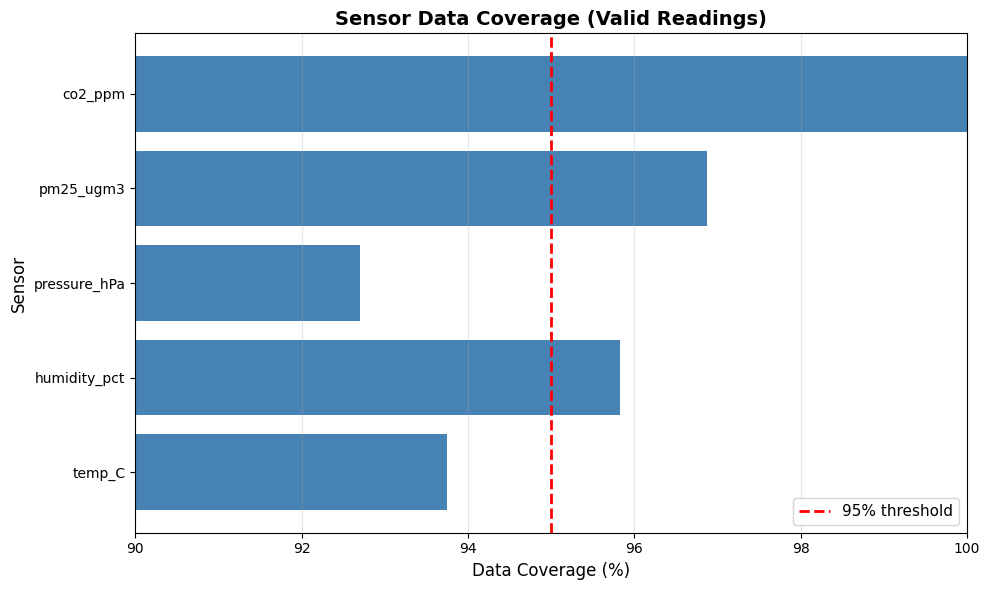

In [9]:
plt.figure(figsize=(10, 6))

plt.barh(quality_df['sensor'], quality_df['coverage_pct'], color='steelblue')
plt.axvline(x=95, color='red', linestyle='--', linewidth=2, label='95% threshold')
plt.xlabel('Data Coverage (%)', fontsize=12)
plt.ylabel('Sensor', fontsize=12)
plt.title('Sensor Data Coverage (Valid Readings)', fontsize=14, fontweight='bold')
plt.xlim(90, 100)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Use Case: Time-Series with Gaps

Visualize how missing data affects time-series continuity.

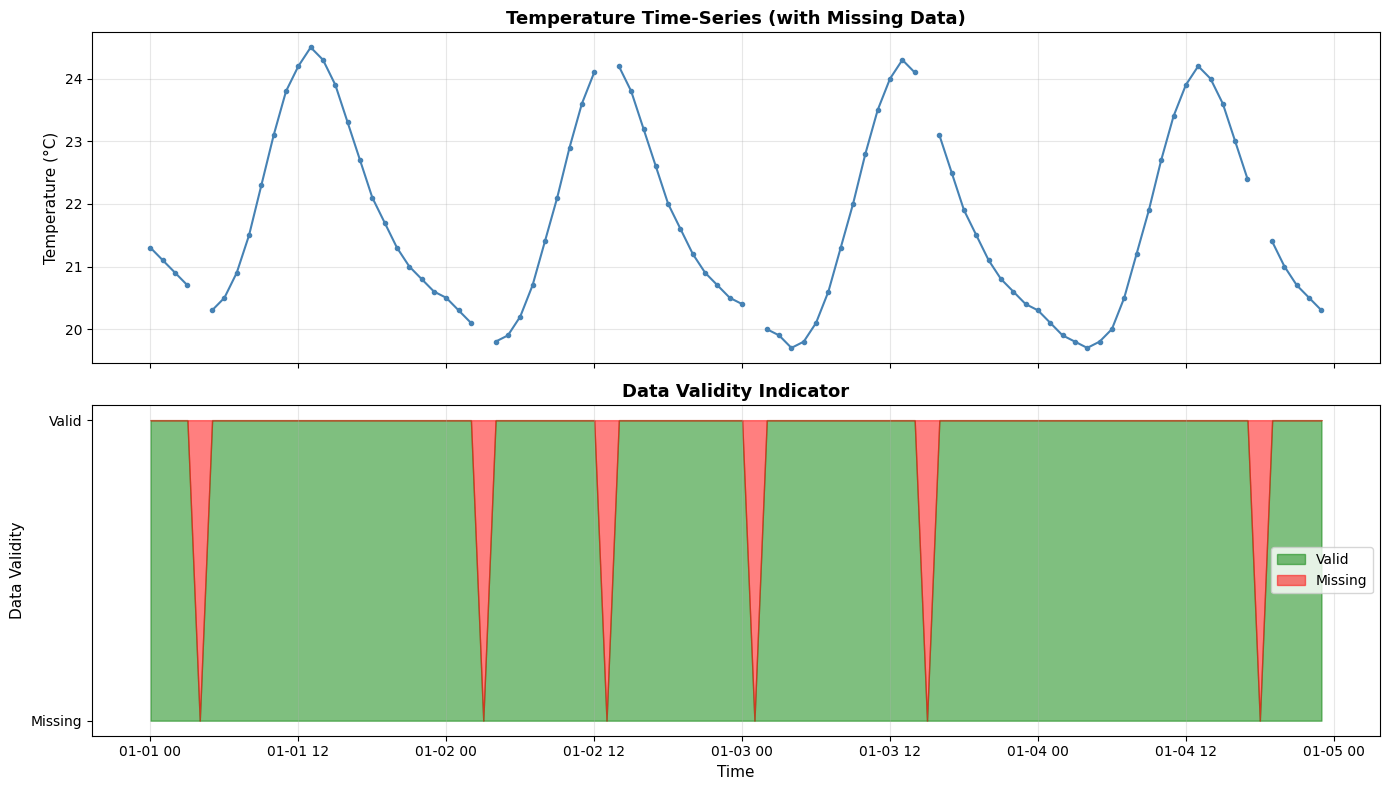

In [10]:
# Plot temperature with gaps
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1: Temperature with gaps
axes[0].plot(df['timestamp'], df['temp_C'], linewidth=1.5, marker='o', markersize=3, color='steelblue')
axes[0].set_ylabel('Temperature (°C)', fontsize=11)
axes[0].set_title('Temperature Time-Series (with Missing Data)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Data validity indicator
temp_valid = (~df['temp_C'].isna()).astype(int)
axes[1].fill_between(df['timestamp'], 0, temp_valid, color='green', alpha=0.5, label='Valid')
axes[1].fill_between(df['timestamp'], temp_valid, 1, color='red', alpha=0.5, label='Missing')
axes[1].set_xlabel('Time', fontsize=11)
axes[1].set_ylabel('Data Validity', fontsize=11)
axes[1].set_title('Data Validity Indicator', fontsize=13, fontweight='bold')
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Missing', 'Valid'])
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Performance Benchmark: Masked vs NaN Operations

Compare performance of masked operations vs standard NaN handling.

In [11]:
# Create large test array with missing values
n = 10_000_000
large_data = np.random.randn(n) * 15 + 22

# Randomly set 5% to NaN
missing_indices = np.random.choice(n, size=int(n * 0.05), replace=False)
large_data[missing_indices] = np.nan

print(f"Benchmark: {n:,} element array, {len(missing_indices):,} missing values (5%)\n")

# Benchmark NumPy nanmean
start = time.perf_counter()
_ = np.nanmean(large_data)
elapsed_numpy = time.perf_counter() - start
print(f"NumPy nanmean:         {elapsed_numpy*1000:.2f} ms")

# Benchmark HPCSeries mean_masked
mask = (~np.isnan(large_data)).astype(np.int32)
data_clean = np.nan_to_num(large_data, nan=0.0)

start = time.perf_counter()
_ = hpcs.mean_masked(data_clean, mask)
elapsed_hpcs = time.perf_counter() - start
print(f"HPCSeries mean_masked: {elapsed_hpcs*1000:.2f} ms")

print(f"\nSpeedup: {elapsed_numpy/elapsed_hpcs:.2f}x faster")
print(f"Throughput: {n/elapsed_hpcs/1e6:.1f} M values/sec")

Benchmark: 10,000,000 element array, 500,000 missing values (5%)

NumPy nanmean:         1850.40 ms
HPCSeries mean_masked: 34.64 ms

Speedup: 53.41x faster
Throughput: 288.7 M values/sec


## What We Learned

### Key Takeaways:

1. **Missing data is common** in real-world sensor data, IoT, environmental monitoring.
   - Sensor failures, transmission errors, maintenance windows cause gaps.

2. **Masked operations** provide an efficient alternative to NaN-based methods.
   - Use boolean masks to mark valid vs invalid data.
   - HPCSeries masked operations skip invalid data efficiently.

3. **Data quality metrics** are essential for monitoring sensor health.
   - Coverage percentage shows reliability.
   - Identify sensors needing maintenance.

4. **HPCSeries masked operations are fast** even with large datasets.
   - SIMD-accelerated, handles millions of data points efficiently.

### HPCSeries Functions Used:

- `hpcs.sum_masked()` — Count valid readings
- `hpcs.mean_masked()` — Mean of valid data
- `hpcs.var_masked()` — Variance of valid data
- `hpcs.median_masked()` — Robust average of valid data
- `hpcs.mad_masked()` — Robust spread of valid data

### Common Use Cases:

| Domain | Use Case | HPCSeries Approach |
|--------|----------|--------------------|
| **IoT** | Sensor networks with failures | Masked operations for valid-only stats |
| **Environmental** | Climate monitoring stations | Handle gaps in weather data |
| **Manufacturing** | Quality control with sensor dropouts | Compute statistics on valid samples |
| **Finance** | Trading data with market closures | Masked analytics for active periods |
| **Healthcare** | Patient monitoring with disconnections | Valid-only heart rate/BP statistics |

### Workflow Summary:

```python
# 1. Identify missing data
mask = (~np.isnan(data)).astype(np.int32)

# 2. Replace NaN with dummy value (doesn't matter, mask will skip it)
data_clean = np.nan_to_num(data, nan=0.0)

# 3. Compute masked statistics
mean = hpcs.mean_masked(data_clean, mask)
median = hpcs.median_masked(data_clean, mask)
```

---

## Summary

You've completed all 5 HPCSeries example notebooks!

1. ✅ **Rolling Mean vs Median** — Robustness to outliers
2. ✅ **Robust Anomaly Detection** — MAD-based detection
3. ✅ **Batched IoT Analytics** — Multi-sensor processing
4. ✅ **Axis Reductions** — Column-wise statistics
5. ✅ **Masked Analytics** — Handling missing data

HPCSeries provides **high-performance, robust statistical computing** for time-series, IoT, finance, and scientific applications.
